In [3]:
import mne
import numpy as np
import matplotlib.pyplot as plt




#initializing training samples and labels
#epochs will be concatenated
epochs_total = np.zeros(1)
labels_total = np.zeros(1)
epochs_train_total = np.zeros(1)


#Using data taken from 108 different people, each performing various MI tasks. In this experiment, we are trying to 
#classify motor imagery of hands vs. feet, only run 6, 10, 14 are relevant
for i in range(108):
    subject = i+1
    runs = [6, 10, 14] 

    
    #the 3 lines below are taken from mne website
    #reading eeg files and concatenate them into one file
    raw_fnames = mne.datasets.eegbci.load_data(subject, runs)
    raw_files = [mne.io.read_raw_edf(f, preload=True, stim_channel='auto') for f in
                 raw_fnames]
    raw = mne.io.concatenate_raws(raw_files)
    raw.rename_channels(lambda x: x.strip('.'))

    #We can print the names of all 64 electrode channels, but only some of them are 
    #relevant to motor imagery.
    #The relevant channels are FC5, FC3, C5, C3, CP5, CP3, FP2, FC4, FC6, C4
    print(raw.ch_names)
    
    #Electrode relevant to right hand MI: FC5, FC3, C5, C3, CP5, CP3
    right_hand = np.array([0,1,7,8,14,15])
    #Electrode relevant to left hand MI: FC2, FC4, FC6, C4
    left_hand = np.array([23, 5, 6, 12])
    
    
    #print the channel names to verify we got the right ones
    for i in right_hand:
        print(raw.ch_names[i])
    
    for i in left_hand:
        print(raw.ch_names[i])

        
        
    #Since it is shown motor imagery will change the mu band (8 -13 Hz) and beta band (13 - 25 Hz), we want to 
    #filter out the noise by applying a band pass filter
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

    
    #the next four lines make raw data into epochs for training
    #The time points when stimuli was presented in front of the experimental subjects 
    #are recorded in stim channel. We take a second before the stimuli happened and four seconds
    #afterward.
    #passing these parameter into mne.Epochs
    events = mne.find_events(raw, shortest_event=0, stim_channel='STI 014')
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
    tmin, tmax = -1., 4.
    event_id = dict(hands=2, feet=3)
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)
    
    
    
    
    #Since right after the stimuli the eeg might not be pure motor imagery
    #only take the 1-2 seconds after as training data
    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    epochs_train = epochs_train.get_data()
    labels = epochs.events[:, -1] - 2

    
    
    #the section below simply concatenate all epochs into one ndarray
    epochs_data = epochs.get_data()
    if epochs_total.size == 1:
        epochs_total = epochs_data
    else:
        epochs_total = np.concatenate((epochs_total, epochs_data), axis = 0)
        
        
    if labels_total.size == 1:
        labels_total = labels
    else:
        labels_total = np.concatenate((labels_total, labels), axis = 0)
        
        
    if epochs_train_total.size == 1:
        epochs_train_total = epochs_train
    else:
        epochs_train_total = np.concatenate((epochs_train_total, epochs_train), axis = 0)
        

        
#printing the shape of the samples and labels to make sure they make sense
print(epochs_total.shape)
print(labels_total.shape)
print(epochs_train_total.shape)


Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F

Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S005\S005R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S005\S005R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz', 'STI 014']
Fc5
Fc3
C5
C3
Cp5
Cp3
Fp2
Fc4
Fc6
C4
Se

Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S009\S009R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz', 'STI 014']
Fc5
Fc3
C5
C3
Cp5
Cp3
Fp2
Fc4
Fc6
C4
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwid

Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz', 'STI 014']
Fc5
Fc3
C5
C3
Cp5
Cp3
Fp2
Fc4
Fc6
C4
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Removing orphaned off

l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S018\S018R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_

Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S022\S022R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S022\S022R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\

45 matching events found
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S026\S026R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S026\S026R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S026\S026R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C

EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S030\S030R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S030\S030R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', '

EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S034\S034R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz', 'STI 014']
Fc5
Fc3
C5
C3
Cp5
Cp3
Fp2
Fc4
Fc6
C4
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter l

EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz', 'STI 014']
Fc5
Fc3
C5
C3
Cp5
Cp3
Fp2
Fc4
Fc6
C4
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_b

l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S043\S043R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_

Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S047\S047R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S047\S047R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\

45 matching events found
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S051\S051R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S051\S051R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S051\S051R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C

EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S055\S055R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S055\S055R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', '

EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S059\S059R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz', 'STI 014']
Fc5
Fc3
C5
C3
Cp5
Cp3
Fp2
Fc4
Fc6
C4
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter l

EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz', 'STI 014']
Fc5
Fc3
C5
C3
Cp5
Cp3
Fp2
Fc4
Fc6
C4
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_b

Fc6
C4
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S068\S068R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready

h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 264 samples (1.650 sec) selected
Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S072\S072R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S072\S072R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...

Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S076\S076R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S076\S076R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S076\S076R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 s

EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S080\S080R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S080\S080R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', '

EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S084\S084R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz', 'STI 014']
Fc5
Fc3
C5
C3
Cp5
Cp3
Fp2
Fc4
Fc6
C4
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter l

<ipython-input-3-d9933d12968d>:25: RuntimeWarning: EDF+ with overlapping events are not fully supported
  raw_files = [mne.io.read_raw_edf(f, preload=True, stim_channel='auto') for f in
<ipython-input-3-d9933d12968d>:25: RuntimeWarning: EDF+ with overlapping events are not fully supported
  raw_files = [mne.io.read_raw_edf(f, preload=True, stim_channel='auto') for f in


Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
EDF+ with overlapping events are not fully supported
EDF+ with overlapping events are not fully supported
Ready.
Extracting edf Parameters from C:\Users\Kun\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S088\S088R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 15871  =      0.000 ...   123.992 secs...


<ipython-input-3-d9933d12968d>:25: RuntimeWarning: EDF+ with overlapping events are not fully supported
  raw_files = [mne.io.read_raw_edf(f, preload=True, stim_channel='auto') for f in
<ipython-input-3-d9933d12968d>:25: RuntimeWarning: EDF+ with overlapping events are not fully supported
  raw_files = [mne.io.read_raw_edf(f, preload=True, stim_channel='auto') for f in


EDF+ with overlapping events are not fully supported
EDF+ with overlapping events are not fully supported
Ready.
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz', 'STI 014']
Fc5
Fc3
C5
C3
Cp5
Cp3
Fp2
Fc4
Fc6
C4
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 211 samples (1.648 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 211 samples (1.648 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_t

<ipython-input-3-d9933d12968d>:25: RuntimeWarning: EDF+ with overlapping events are not fully supported
  raw_files = [mne.io.read_raw_edf(f, preload=True, stim_channel='auto') for f in
<ipython-input-3-d9933d12968d>:25: RuntimeWarning: EDF+ with overlapping events are not fully supported
  raw_files = [mne.io.read_raw_edf(f, preload=True, stim_channel='auto') for f in


0 bad epochs dropped


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [63]:
#the first naive approach would be feeding frequency series directly into a logistic regression classifier
#training sample size: 3504
#testing sample size: 390
#input shape: 10 selected channels X 161 frequency points (DFT of time series)
import sklearn.linear_model
from sklearn.model_selection import ShuffleSplit  
from scipy.fftpack import fft, ifft


clf = sklearn.linear_model.LogisticRegression(C=1)
#Using 10 fold cross validation
cv = ShuffleSplit(n_splits=10)
scores = []

for train_idx, test_idx in cv.split(labels_total):
    y_train, y_test = labels_total[train_idx], labels_total[test_idx]
    X_train = epochs_train_total[train_idx][:,index]
    
    X_train = fft(X_train)
    
    #Since logistic regression only handles 1D data, the 2D eeg data is flattened
    X_train = X_train.reshape(1610,3504).T
    X_test = epochs_train_total[test_idx][:,index]
    X_test = fft(X_test)
    X_test = X_test.reshape(1610,390).T
    
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(clf.score(X_test, y_test))


    
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


#As predicted, the accuracy is only 48%


C:\Users\Kun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


Classification accuracy: 0.495641 / Chance level: 0.501027


In [24]:
# A classifier that shows good performance is from this paper
#The idea is as below:
    #1. take the covariance matrix of the input matrix. This can be calculated as A^T * A
    #2. Project the covariance matrix to either Euclidean space or Riemannian space
    #3. Calculate the centroid of each class
    #4. To classify a new point, simply find the class with the nearest centroid

import sklearn 
import numpy as np
from sklearn.model_selection import ShuffleSplit
import pyriemann.classification
import pyriemann.estimation


# a function that verify the covariance matrix is indeed positive definitive and 
# proper to be projected onto a Riemannian space
# From math, as long as all the eigen values of a matrix are positive, it is positive definitive
def check_pos_def(x):
    return np.all(np.linalg.eigvals(x) >= 0)


#Only use the channels that are relevant to motor imagery to decrease noise
index = np.concatenate((left_hand,right_hand))


cv = ShuffleSplit(n_splits=10)
scores = []
epochs_data = epochs_train_total

for train_idx, test_idx in cv.split(labels_total):
    y_train, y_test = labels_total[train_idx], labels_total[test_idx]
    X_train = epochs_data[train_idx]
    X_test = epochs_data[test_idx]

    
    #Converting input matrix into covariance matrices
    cov =  pyriemann.estimation.Covariances('lwf')
    cov_X_train = cov.transform(X_train)
    cov_X_test = cov.transform(X_test)
    

    mdm = pyriemann.classification.MDM(metric=dict(mean='riemann', distance='riemann'))
    mdm.fit(cov_X_train, y_train)
    y_predict = mdm.predict(cov_X_test)
    
    
    
    scores.append(sklearn.metrics.accuracy_score(y_predict, y_test))


class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


Classification accuracy: 0.530769 / Chance level: 0.516667


In [38]:
#However, when only testing on the same person, the accuracy is good
# The accuracy is 72%
# This shows that covariance matrix does reveal a characteristics of eeg signal
# the difficulty could come from transfer learning, the experience from on subject cannot be applied to another subject directly

cv = ShuffleSplit(n_splits=10)
scores = []
epochs_data = epochs_train_total[:50,:]


for train_idx, test_idx in cv.split(labels_total[:50]):
    y_train, y_test = labels_total[train_idx], labels_total[test_idx]
    X_train = epochs_data[train_idx]
    X_test = epochs_data[test_idx]
    
    #Converting input matrix into covariance matrices
    cov =  pyriemann.estimation.Covariances('lwf')
    cov_X_train = cov.transform(X_train)
    cov_X_test = cov.transform(X_test)
    mdm = pyriemann.classification.MDM(metric=dict(mean='riemann', distance='riemann'))
    mdm.fit(cov_X_train, y_train)
    y_predict = mdm.predict(cov_X_test)
    scores.append(sklearn.metrics.accuracy_score(y_predict, y_test))


class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


Classification accuracy: 0.720000 / Chance level: 0.501027


In [39]:
# another classifier based on covariance matrix projected on Riemmanian spaced is shown in this paper by ths same author
#whenn applied on a smaller sample size, the accuracy of the tangent space classifier is good
#it agains shows that the covariance matrix of eeg data contains useful information
# but the difficulty is in transfer learning

#even when we increase sample size to 150, the accuracy achieve 72%

import sklearn 
import numpy as np
import pyriemann.estimation
import pyriemann.classification




cv = ShuffleSplit(n_splits=10)
scores = []
epochs_data = epochs_train_total[:150,:]

for train_idx, test_idx in cv.split(labels_total[:150]):
    y_train, y_test = labels_total[train_idx], labels_total[test_idx]
    X_train = epochs_data[train_idx]
    X_test = epochs_data[test_idx]

    
    cov =  pyriemann.estimation.Covariances('lwf')
    cov_X_train = cov.transform(X_train)
    cov_X_test = cov.transform(X_test)
    
    TSclassifier = pyriemann.classification.TSclassifier(metric='riemann')
    TSclassifier.fit(cov_X_train, y_train)
    
    
    y_predict = TSclassifier.predict(cov_X_test)
    scores.append(sklearn.metrics.accuracy_score(y_predict, y_test))


class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


135 64
15 64
135 64
15 64
135 64
15 64
135 64
15 64
135 64
15 64
135 64
15 64
135 64
15 64
135 64
15 64
135 64
15 64
135 64
15 64
Classification accuracy: 0.720000 / Chance level: 0.501027


In [46]:
#Below is a function that takes the upper half of a matrix and put them in an array

#As we can see, the result 
def takeupper(m):
    print(m.shape)
    ret = []
    for k in range(m.shape[0]):
        row = []
        for i in range(m.shape[1]):
            for j in range(i):
                row.append(m[k][i][j])
        ret.append(row)
    return np.array(ret)



cv = ShuffleSplit(n_splits=10)
scores = []
epochs_data = epochs_train_total
clf = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
labels = labels_total

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]
    X_train = epochs_data[train_idx][:,index]
    X_test = epochs_data[test_idx][:,index]

    cov =  pyriemann.estimation.Covariances('lwf')
    
    #take the covariance matrix of input signal, then only take the upper half to avoid dupplicate
    cov_X_train = cov.transform(X_train)
    X_tr = takeupper(cov_X_train)
    cov_X_test = cov.transform(X_test)
    X_ts = takeupper(cov_X_test)
    

    clf.fit(X_tr, y_train)
    y_predict = clf.predict(X_ts)
    scores.append(sklearn.metrics.accuracy_score(y_predict, y_test))


    
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


(3504, 10, 10)
(390, 10, 10)
(3504, 10, 10)
(390, 10, 10)
(3504, 10, 10)
(390, 10, 10)
(3504, 10, 10)
(390, 10, 10)
(3504, 10, 10)
(390, 10, 10)
(3504, 10, 10)
(390, 10, 10)
(3504, 10, 10)
(390, 10, 10)
(3504, 10, 10)
(390, 10, 10)
(3504, 10, 10)
(390, 10, 10)
(3504, 10, 10)
(390, 10, 10)
Classification accuracy: 0.578462 / Chance level: 0.501027


In [48]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import pyriemann.estimation



K.clear_session()

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = []

index = np.concatenate((left_hand, right_hand))

epochs_data = epochs_train_total
labels = labels_total

print(epochs_data.shape)



for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]
    X_train = epochs_data[train_idx][:,index]
    X_test = epochs_data[test_idx][:,index]
    cov =  pyriemann.estimation.Covariances('lwf')
    cov_X_train = cov.transform(X_train)
    cov_X_test = cov.transform(X_test)
    
    print("the shape of cov matrix is {}".format(cov_X_train.shape))

    num_train = cov_X_train.shape[0]
    num_test = cov_X_test.shape[0]
    
    cov_X_train = cov_X_train.reshape(num_train, 1, 10, 10)
    cov_X_test = cov_X_test.reshape(num_test, 1, 10, 10)

    x_train = cov_X_train
    x_test = cov_X_test



    num_classes = 2

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = Sequential()
    model.add(Conv2D(8, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(1,10, 10), data_format='channels_first'))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=0.01),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=256,
              epochs=4,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    scores.append(score)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


(3894, 64, 161)
the shape of cov matrix is (3115, 10, 10)
Train on 3115 samples, validate on 779 samples
Epoch 1/4
3115/3115 [==============================] - 0s - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6932 - val_acc: 0.4878
Epoch 2/4
3115/3115 [==============================] - 0s - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6932 - val_acc: 0.4878
Epoch 3/4
3115/3115 [==============================] - 0s - loss: 0.6932 - acc: 0.4976 - val_loss: 0.6932 - val_acc: 0.4878
Epoch 4/4
3115/3115 [==============================] - 0s - loss: 0.6932 - acc: 0.5085 - val_loss: 0.6932 - val_acc: 0.4878
Test loss: 0.693174670459
Test accuracy: 0.487804878202
the shape of cov matrix is (3115, 10, 10)
Train on 3115 samples, validate on 779 samples
Epoch 1/4
3115/3115 [==============================] - 0s - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6932 - val_acc: 0.4981
Epoch 2/4
3115/3115 [==============================] - 0s - loss: 0.6932 - acc: 0.4831 - val_loss: 0.6931 - val_acc: 0.4981
Epoch 

C:\Users\Kun\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


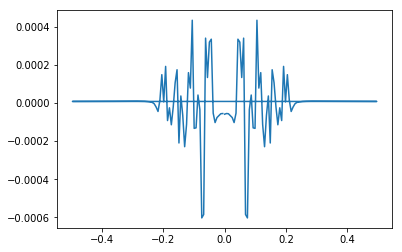

In [58]:
from scipy.fftpack import fft, ifft

signal = epochs_train_total[0,0,:]
val = fft(signal)
freq = np.fft.fftfreq(signal.size)

plt.plot(freq, val)
plt.show()